In [1]:
print("....Starting chapter 4 ")

....Starting chapter 4 


In [2]:
GPT_CONFIG_124M = {
    "vocab_size":50257,
    "context_length":1024,
    "emb_dim":768,
    "n_heads":12,
    "n_layers":12,
    "drop_rate":0.1,
    "bias_":False
    }

In [3]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg): # ----->cfg stands for configuration of the model
        super().__init__()
        self.token_embedding=nn.Embedding(cfg['vocab_size'],cfg['emb_dim'])
        self.positional_embedding=nn.Embedding(cfg['context_length'],cfg['emb_dim'])
        self.drop_emnd=nn.Dropout(cfg['drop_rate'])
        self.transformer_blocks= nn.Sequential(
            *[DummyTransformerBlock(cfg)
              for _ in range(cfg['n_layers'])]
        )
        self.final_norm=DummyLayerNorm(cfg['emb_dim'])

        self.out_head=nn.Linear(
            cfg['emb_dim'],cfg['vocab_size']
            ,bias=False
        )


    def forward(self,in_idx):
        batch_size , seq_len= in_idx.shape

        tok_embeds=self.token_embedding(in_idx)
        pos_embeds=self.positional_embedding(
            torch.arange(seq_len,device=in_idx.device)
        ) 

        x = tok_embeds + pos_embeds
        x=self.drop_emnd(x)
        x=self.transformer_blocks(x)
        x=self.final_norm(x)

        logits=self.out_head(x)

        return logits
    

class DummyTransformerBlock(nn.Module):
    def __init__(self,cfg ):
        super().__init__()

    def forward(self,x):
        return x 

class DummyLayerNorm(nn.Module):
    def __init__(self,normalizerd_shape,eps=1e-5 ):
        super().__init__()

    def forward(self,x):
        return x                   



In [4]:
import tiktoken

GPT_toknizer=tiktoken.get_encoding('gpt2')
batch=[]
txt1="I regret pursuing "
txt2="I am an engineer"

batch.append(torch.tensor(GPT_toknizer.encode(txt1)))
batch.append(torch.tensor(GPT_toknizer.encode(txt2)))

batch=torch.stack(batch,dim=0)

batch

tensor([[   40, 13721, 15461,   220],
        [   40,   716,   281, 11949]])

In [5]:
torch.manual_seed(69)

model=DummyGPTModel(GPT_CONFIG_124M)

logits=model(batch)


logits.shape

torch.Size([2, 4, 50257])

In [6]:
logits

tensor([[[-0.7629,  0.2764, -0.4752,  ..., -0.5381, -0.0084,  1.0804],
         [-0.8403, -0.6271,  0.7980,  ..., -0.0748, -1.7378,  0.9352],
         [ 0.2350,  1.0148,  0.7561,  ..., -1.6156, -0.4738, -0.8695],
         [ 0.8994, -1.1139,  0.1895,  ..., -0.3196,  0.0101,  0.3780]],

        [[-0.0655, -0.2674, -0.1463,  ..., -0.4391,  0.1845,  1.0390],
         [-0.7170,  0.2430,  0.8741,  ..., -0.4582, -0.1968,  0.1792],
         [ 1.0623,  0.7679,  0.7557,  ..., -1.2531, -0.0161, -0.3236],
         [ 0.3861, -0.1189, -0.1243,  ...,  1.0454, -0.2871,  0.7292]]],
       grad_fn=<UnsafeViewBackward0>)

In [7]:
torch.manual_seed(69)

inputs=torch.rand(2,5)
demoNN=nn.Sequential(
    nn.Linear(5,6),
    nn.ReLU()
)
out=demoNN(inputs)
print(out)

tensor([[0.1514, 0.0000, 0.2192, 0.0000, 0.3302, 0.0000],
        [0.2511, 0.0000, 0.0000, 0.1048, 0.2901, 0.0000]],
       grad_fn=<ReluBackward0>)


In [8]:
out.sum(dim=-1,keepdim=True)/out.shape[-1]

tensor([[0.1168],
        [0.1077]], grad_fn=<DivBackward0>)

In [9]:
mean=out.mean(dim=-1,keepdim=True)
mean

tensor([[0.1168],
        [0.1077]], grad_fn=<MeanBackward1>)

In [10]:
variance=out.var(dim=-1,keepdim=True)
variance

tensor([[0.0196],
        [0.0177]], grad_fn=<VarBackward0>)

In [11]:
normalized_outputs = (out - mean)/torch.sqrt(variance)

In [12]:
normalized_mean=normalized_outputs.mean(dim=-1,keepdim=True)

In [13]:
normalized_variance=normalized_outputs.var(dim=-1,keepdim=True)


In [14]:
torch.set_printoptions(sci_mode=False)
print("mean:",normalized_mean)
print("variance:",normalized_variance)

mean: tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
variance: tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [15]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps=1e-5
        self.scale=nn.Parameter(torch.ones(emb_dim))
        self.shift=nn.Parameter(torch.zeros(emb_dim))
    def forward(self,x):
        mean=x.mean(dim=-1,keepdim=True)
        var=x.var(dim=-1,keepdim=True , unbiased=False)
        norm_x=(x-mean) / torch.sqrt(var+self.eps)
        return self.scale * norm_x + self.shift



In [16]:
batch_example=torch.rand(2,5)
batch_example

tensor([[0.6072, 0.5147, 0.7654, 0.5434, 0.3774],
        [0.3056, 0.6771, 0.3802, 0.2426, 0.8268]])

In [17]:
ln = LayerNorm(emb_dim=5)
out_ln=ln(batch_example)
mean=out_ln.mean(dim=-1,keepdim=True)
var=out_ln.var(dim=-1,keepdim=True,unbiased=False)
print('mean:',mean)
print("variance:\n",var)


mean: tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
variance:
 tensor([[0.9994],
        [0.9998]], grad_fn=<VarBackward0>)


In [18]:
import torch
import torch.nn as nn

class Gelu(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))


In [19]:
gelu=Gelu()
gelu(torch.tensor(2.))

tensor(1.9546)

In [20]:
import torch.nn.functional as f
gelu=f.gelu(torch.tensor(2.),approximate='tanh')
gelu

tensor(1.9546)

/var/folders/hp/y1d826dx5fb1405ppnjjm4700000gn/T/ipykernel_57390/394656700.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2 / torch.pi)) * torch.tensor((x + 0.044715 * torch.pow(x, 3)))))


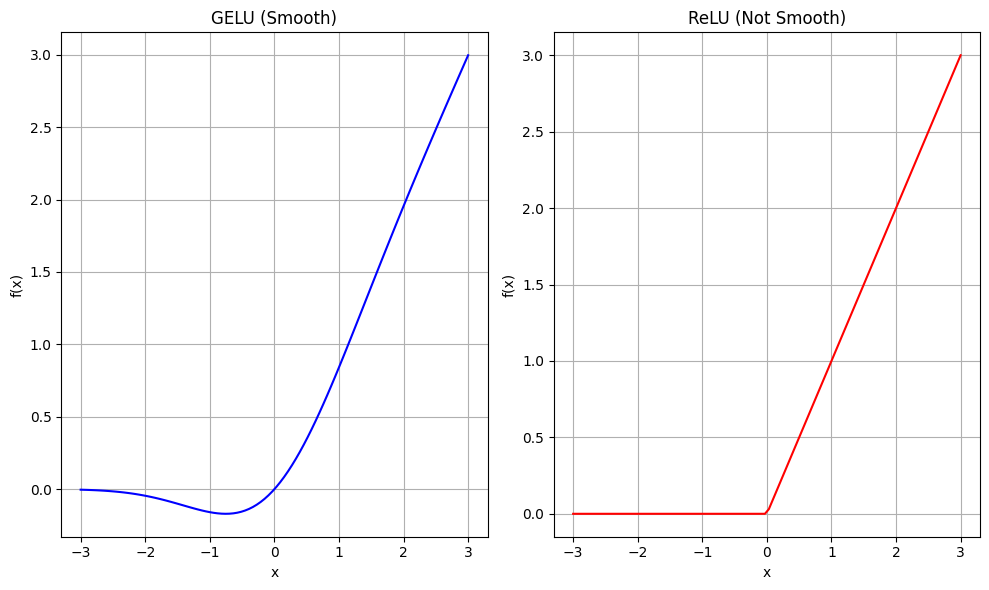

In [21]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Define the functions
def gelu(x):
    return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2 / torch.pi)) * torch.tensor((x + 0.044715 * torch.pow(x, 3)))))

def relu(x):
    return torch.maximum(torch.tensor(0.0), x)

# Generate x values
x_vals = torch.linspace(-3, 3, 100)

# Compute function values
gelu_vals = gelu(x_vals)
relu_vals = relu(x_vals)

# Plot
plt.figure(figsize=(10, 6))

# Plot GELU
plt.subplot(1, 2, 1)
plt.plot(x_vals.numpy(), gelu_vals.numpy(), label="GELU", color="b")
plt.title("GELU (Smooth)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)

# Plot ReLU
plt.subplot(1, 2, 2)
plt.plot(x_vals.numpy(), relu_vals.numpy(), label="ReLU", color="r")
plt.title("ReLU (Not Smooth)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)

plt.tight_layout()
plt.show()


In [22]:
class FFN(nn.Module):
    def __init__(self,cfg ):
        super().__init__()
        self.layers=nn.Sequential(
            nn.Linear(cfg["emb_dim"],4 * cfg["emb_dim"]),
            Gelu(),
            nn.Linear(4 * cfg["emb_dim"],cfg["emb_dim"])
        )
    def forward(self,x):
        return self.layers(x)    

In [23]:
ffn=FFN(
    GPT_CONFIG_124M
)
x = torch.tensor(torch.rand(2,3,768))
out=ffn(x)
out.shape



/var/folders/hp/y1d826dx5fb1405ppnjjm4700000gn/T/ipykernel_57390/2699759041.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(torch.rand(2,3,768))


torch.Size([2, 3, 768])

In [24]:
class EXResidualConnections(nn.Module):
    def __init__(self,layer_sizes,use_shortcut):
        super().__init__()
        self.use_shortcut=use_shortcut
        self.layers=nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0],layer_sizes[1]),
                          Gelu()),
            nn.Sequential(nn.Linear(layer_sizes[1],layer_sizes[2]),
                          Gelu()),
            nn.Sequential(nn.Linear(layer_sizes[2],layer_sizes[3]),
                          Gelu()),
            nn.Sequential(nn.Linear(layer_sizes[3],layer_sizes[4]),
                          Gelu()),
            nn.Sequential(nn.Linear(layer_sizes[4],layer_sizes[5]),
                          Gelu())
        ])            
    def forward(self,x):
        for layer in self.layers:
            layer_output=layer(x)
            if self.use_shortcut and x.shape==layer_output.shape:
                x=x+layer_output
            else:
                x=layer_output
        return x             


In [25]:
torch.manual_seed(69)
layer_sizes=[3,3,3,3,3,1]
sample_input = torch.rand(1,3)
model_without_skip_connections = EXResidualConnections(
    layer_sizes,use_shortcut=False
)



In [26]:
def print_gradients(model , x):
    output = model(x)
    target = torch.tensor([[0.]])

    loss=nn.MSELoss()
    loss=loss(output,target)

    loss.backward()

    for name,param in model.named_parameters():
        if 'weight' in name:
            print(f'{name} has gradient mean of {param.grad.abs().mean().item()}')

In [27]:
print_gradients(model_without_skip_connections,sample_input)

layers.0.0.weight has gradient mean of 3.2735970307840034e-05
layers.1.0.weight has gradient mean of 4.1062277887249365e-05
layers.2.0.weight has gradient mean of 6.823352305218577e-05
layers.3.0.weight has gradient mean of 0.0008357462356798351
layers.4.0.weight has gradient mean of 0.003820376703515649


In [28]:
# now we define a model which has skip connections 
torch.manual_seed(69)

model_with_skip_connections=EXResidualConnections(
    layer_sizes,use_shortcut=True
)
print_gradients(model_with_skip_connections,sample_input)

layers.0.0.weight has gradient mean of 0.06841462850570679
layers.1.0.weight has gradient mean of 0.0576305128633976
layers.2.0.weight has gradient mean of 0.03812249377369881
layers.3.0.weight has gradient mean of 0.03064136952161789
layers.4.0.weight has gradient mean of 0.45960965752601624


In [29]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
        "d_out must be divisible by num_heads"
        
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                      diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        
        # Linear transformations
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        # Reshape to include heads dimension
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Compute attention scores
        attn_scores = queries @ keys.transpose(-2, -1)
        
        # Apply mask
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        # Compute attention weights
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # Compute context vectors
        context_vec = attn_weights @ values
        context_vec = context_vec.transpose(1, 2).contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        
        return context_vec

In [30]:


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.attention=MultiHeadAttention(
            d_in=cfg['emb_dim'],
            d_out=cfg['emb_dim'],
            context_length=cfg['context_length'],
            num_heads=cfg['n_heads'],
            dropout=cfg['drop_rate'],
            qkv_bias=cfg['bias_']

        )
        self.ff=FFN(cfg)
        self.norm1=LayerNorm(cfg['emb_dim'])
        self.norm2=LayerNorm(cfg['emb_dim'])
        self.dropout=nn.Dropout(cfg['drop_rate'])

    def forward(self,x):
        shortcut=x
        x=self.norm1(x)
        x=self.attention(x)
        x=self.dropout(x)
        x=x+shortcut


        shortcut=x
        x=self.norm2(x)
        x=self.ff(x)
        x=self.dropout(x)
        x=x+shortcut
        return x 




In [31]:
torch.manual_seed(69)
x=torch.rand(2,4,768) # a batch with 4 input tokens and each token has a dimension of 768
block=TransformerBlock(GPT_CONFIG_124M)
output=block(x)
output.shape


torch.Size([2, 4, 768])

In [32]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb=nn.Embedding(cfg['vocab_size'],cfg['emb_dim'])
        self.pos_emb=nn.Embedding(cfg['context_length'],cfg['emb_dim'])
        self.drop_emb=nn.Dropout(cfg['drop_rate'])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )
        self.final_norm=LayerNorm(cfg['emb_dim'])
        self.out_head=nn.Linear(
            cfg['emb_dim'],cfg['vocab_size'],bias=False
        )

    def forward(self,in_idx):  # -----> in idx stands for the input ids the model will recieve 
        batch_size,seq_len = in_idx.shape
        token_embds=self.tok_emb(in_idx)

        pos_emb=self.pos_emb(
            torch.arange(seq_len,device=in_idx.device))

        x=token_embds + pos_emb
        x=self.drop_emb(x)
        x=self.trf_blocks(x)
        x=self.final_norm(x)
        logits=self.out_head(x)
        return logits
    




In [74]:
torch.manual_seed(69)
model=GPTModel(GPT_CONFIG_124M)

out=model(batch)

In [75]:
out.shape

torch.Size([2, 4, 50257])

In [35]:
total_params = sum(p.numel() for p in model.parameters())
print(f"the total number of parameters: {total_params:,}")


the total number of parameters: 163,009,536


In [39]:
GPT_124M_params=(
    total_params - sum(p.numel()
    for p in model.out_head.parameters())
)
print(f"Number of trainable paramters is {GPT_124M_params:,} using weight tying")


Number of trainable paramters is 124,412,160 using weight tying


In [44]:
ffn_number_of_params=(
    sum(p.numel()
        for p in block.ff.parameters())
)

attn_block_num_params=(
    sum(p.numel() 
        for p in block.attention.parameters())
)
print(f'number of ffn parameters:{ffn_number_of_params:,}')
print(f'number of multi head attention parameters:{attn_block_num_params:,}')

number of ffn parameters:4,722,432
number of multi head attention parameters:2,360,064


In [40]:
block

TransformerBlock(
  (attention): MultiHeadAttention(
    (W_query): Linear(in_features=768, out_features=768, bias=False)
    (W_key): Linear(in_features=768, out_features=768, bias=False)
    (W_value): Linear(in_features=768, out_features=768, bias=False)
    (out_proj): Linear(in_features=768, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ff): FFN(
    (layers): Sequential(
      (0): Linear(in_features=768, out_features=3072, bias=True)
      (1): Gelu()
      (2): Linear(in_features=3072, out_features=768, bias=True)
    )
  )
  (norm1): LayerNorm()
  (norm2): LayerNorm()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [45]:
total_size_bytes=total_params * 4  # 1byte = bits 
total_size_mb = total_size_bytes / (1024 *1024) # 1mb = 1024 x 1024 bytes
print(f'Total size of the model:{total_size_mb:.2f} MB')

Total size of the model:621.83 MB


In [46]:
# exercise 4.2

GPT_MEDIUM_CONFIG = {
    "vocab_size":50257,
    "context_length":1024,
    "emb_dim":1024,
    "n_heads":16,
    "n_layers":24,
    "drop_rate":0.1,
    "bias_":False
    }



In [48]:
GPT_MEDIUM = GPTModel(GPT_MEDIUM_CONFIG)
GPT_MEDIUM

GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=False)
        (W_key): Linear(in_features=1024, out_features=1024, bias=False)
        (W_value): Linear(in_features=1024, out_features=1024, bias=False)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FFN(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): Gelu()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(

In [49]:
GPT_MEDIUM_NUM_OF_PARAMS = sum(p.numel() for p in GPT_MEDIUM.parameters())

In [53]:
print(f'NUMBER OF PARAMETERS IN GPT-M: {GPT_MEDIUM_NUM_OF_PARAMS:,}')

NUMBER OF PARAMETERS IN GPT-M: 406,212,608


In [54]:
# exercise 4.2

GPT_LARGE_CONFIG = {
    "vocab_size":50257,
    "context_length":1024,
    "emb_dim":1280,
    "n_heads":20,
    "n_layers":36,
    "drop_rate":0.1,
    "bias_":False
    }



In [56]:
GPT_LARGE = GPTModel(GPT_LARGE_CONFIG)
GPT_LARGE_NUM_OF_PARAMS = sum(p.numel() for p in GPT_LARGE.parameters())

In [57]:
print(f'NUMBER OF PARAMETERS IN GPT-L: {GPT_LARGE_NUM_OF_PARAMS:,}')

NUMBER OF PARAMETERS IN GPT-L: 838,220,800


In [62]:
GPT_X_LARGE_CONFIG = {
    "vocab_size":50257,
    "context_length":1024,
    "emb_dim":1600,
    "n_heads":25,
    "n_layers":48,
    "drop_rate":0.1,
    "bias_":False
    }


In [63]:
GPT_X_LARGE = GPTModel(GPT_X_LARGE_CONFIG)
GPT_X_LARGE_NUM_OF_PARAMS = sum(p.numel() for p in GPT_X_LARGE.parameters())

In [64]:
print(f'NUMBER OF PARAMETERS IN GPT-XL: {GPT_X_LARGE_NUM_OF_PARAMS:,}')

NUMBER OF PARAMETERS IN GPT-XL: 1,637,792,000


In [78]:
def generate_text_simple(model,idx,                     #---->idx is a shape of (batch,ntokens)
                        max_new_tokens,context_size ):  
    for _ in range(max_new_tokens):
        idx_condn=idx[: , -context_size:]  #---> truncation part if the input exceeds the context size
        with torch.no_grad():
            logits=model(idx_condn)

        logits=logits[: , -1 , :]     # here this part focuses only on the last time step 
        probas = torch.softmax(logits , dim=-1) # converting the logits to probabilities of the last token 
        idx_next=torch.argmax(probas,dim=-1,keepdim=True)  # finding the token with the highest probability
        idx=torch.cat((idx,idx_next),dim=-1)      # appends the new token to the previous input

    return idx       

In [79]:
start_context = "HI I AM GPT SMALL TRAINED BY "
encoded = GPT_toknizer.encode(start_context)
print('encoded_input: ',encoded)
encoded_tensor=torch.tensor(encoded).unsqueeze(0)
encoded_tensor.shape

encoded_input:  [25374, 314, 3001, 402, 11571, 9447, 7036, 29125, 1268, 1961, 11050, 220]


torch.Size([1, 12])

In [82]:
model.eval()
out=generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M['context_length']
)
print(out)


tensor([[25374,   314,  3001,   402, 11571,  9447,  7036, 29125,  1268,  1961,
         11050,   220, 15832, 18006, 25893, 17028, 32241, 28452, 39621,  5993,
         25911, 15290]])


In [85]:
generated_text=GPT_toknizer.decode(
    out.squeeze(0).tolist()
)

In [86]:
generated_text

'HI I AM GPT SMALL TRAINED BY  formally Wildlife excuses consultant SunnyMechiframeamily Basketball mock'